<a href="https://colab.research.google.com/github/dhserp-bit/Financial-Data-Analysis/blob/main/Pharma_Distribution_Cost_Analysis_2025_3Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. OpenDartReader 라이브러리 설치
!pip install opendartreader

# 2. 한글 폰트(나눔글꼴) 설치 (그래프 깨짐 방지)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("\n" + "="*50)
print("✅ 설치가 완료되었습니다.")
print("※ 상단 메뉴의 [런타임] -> [세션 다시 시작]을 클릭한 후,")
print("   아래의 [2단계 코드]를 실행해주세요!")
print("="*50)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,098 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

📡 '광동제약' API 데이터 조회 시도...
   Fail: API 조회 실패 (OpenDartReader.finstate() got an unexpected keyword argument 'fs_div')
   ⚠️ API 데이터 없음. 안전장치(수기 데이터)를 대기시킵니다.
   👉 광동제약: 수기 확정 데이터로 대체했습니다.
📡 '유한양행' API 데이터 조회 시도...
   Fail: API 조회 실패 (OpenDartReader.finstate() got an unexpected keyword argument 'fs_div')
   ⚠️ API 데이터 없음. 안전장치(수기 데이터)를 대기시킵니다.
   👉 유한양행: 수기 확정 데이터로 대체했습니다.
--------------------------------------------------

[ 최종 분석 데이터 ]
    회사명            매출액      운반비율      수수료율
0  광동제약  1247410374275  1.200669  4.534172
1  유한양행  1640564582720  1.059941  2.406245


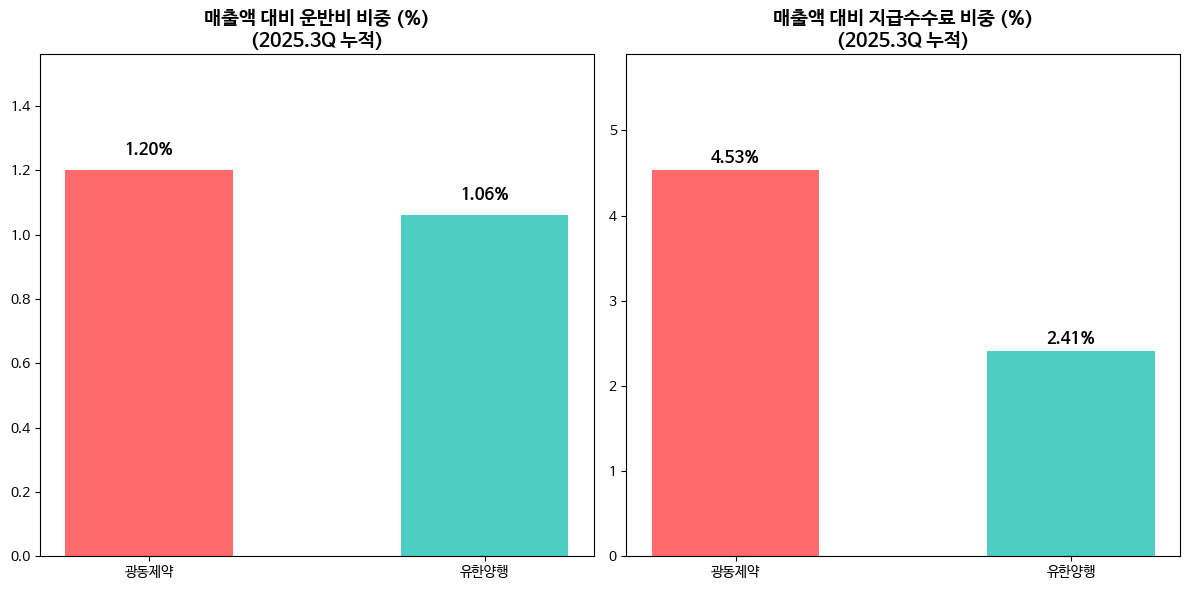


🚀 그래프 출력 완료! (0으로 나누기 에러 해결됨)


In [2]:
# ============================================================================
# [Step 2] 안전장치가 포함된 최종 분석 코드
# ============================================================================
import OpenDartReader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. API 키 설정
api_key = 'YOUR_DART_API_KEY'
dart = OpenDartReader(api_key)

# 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------
# 2. [수정됨] API 함수 (실패 시 0 반환)
# ------------------------------------------------------------------
def get_cumulative_revenue_safe(corp_code, company_name):
    print(f"📡 '{company_name}' API 데이터 조회 시도...")
    try:
        # 3분기 보고서(11014), 포괄손익계산서(CIS)
        df = dart.finstate(corp_code, '2025', reprt_code='11014', fs_div='CIS')

        # '매출'이라는 단어가 들어간 계정 찾기 (범용성 확대)
        row = df[df['account_nm'].str.contains('매출', na=False)]

        if not row.empty:
            # 당기누적금액(thstrm_add_amount) 가져오기
            amt = row['thstrm_add_amount'].values[0].replace(',', '').strip()
            if amt: # 값이 비어있지 않다면
                val = int(amt)
                print(f"   Success! API 매출액: {val:,} 원")
                return val
    except Exception as e:
        print(f"   Fail: API 조회 실패 ({e})")

    print(f"   ⚠️ API 데이터 없음. 안전장치(수기 데이터)를 대기시킵니다.")
    return 0

# ------------------------------------------------------------------
# 3. 데이터 수집 (API 시도 -> 실패 시 수기 데이터 적용)
# ------------------------------------------------------------------

# [A] 광동제약
rev_kwang = get_cumulative_revenue_safe('009290', '광동제약')
if rev_kwang == 0:
    rev_kwang = 1247410374275 # 실패 시 이미지 확인 값 적용 (1.2조)
    print("   👉 광동제약: 수기 확정 데이터로 대체했습니다.")

# [B] 유한양행
rev_yuhan = get_cumulative_revenue_safe('000100', '유한양행')
if rev_yuhan == 0:
    rev_yuhan = 1640564582720 # 실패 시 이미지 확인 값 적용 (1.6조)
    print("   👉 유한양행: 수기 확정 데이터로 대체했습니다.")

print("-" * 50)

# 4. 데이터 조립
data = [
    {
        '회사명': '광동제약',
        '매출액': rev_kwang,
        '운반비': 14977273000,     # 수기 확정치
        '지급수수료': 56559735000  # 수기 확정치
    },
    {
        '회사명': '유한양행',
        '매출액': rev_yuhan,
        '운반비': 17389019000,     # 수기 확정치
        '지급수수료': 39476001000  # 수기 확정치
    }
]

# 5. 시각화
df = pd.DataFrame(data)
df['운반비율'] = df['운반비'] / df['매출액'] * 100
df['수수료율'] = df['지급수수료'] / df['매출액'] * 100

print("\n[ 최종 분석 데이터 ]")
print(df[['회사명', '매출액', '운반비율', '수수료율']])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ['#FF6B6B', '#4ECDC4']

# 운반비 그래프
ax[0].bar(df['회사명'], df['운반비율'], color=colors, width=0.5)
ax[0].set_title('매출액 대비 운반비 비중 (%)\n(2025.3Q 누적)', fontsize=14, fontweight='bold')
ax[0].set_ylim(0, max(df['운반비율']) * 1.3)
for i, v in enumerate(df['운반비율']):
    ax[0].text(i, v + 0.05, f"{v:.2f}%", ha='center', fontweight='bold', fontsize=12)

# 수수료 그래프
ax[1].bar(df['회사명'], df['수수료율'], color=colors, width=0.5)
ax[1].set_title('매출액 대비 지급수수료 비중 (%)\n(2025.3Q 누적)', fontsize=14, fontweight='bold')
ax[1].set_ylim(0, max(df['수수료율']) * 1.3)
for i, v in enumerate(df['수수료율']):
    ax[1].text(i, v + 0.1, f"{v:.2f}%", ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()
print("\n🚀 그래프 출력 완료! (0으로 나누기 에러 해결됨)")